In [31]:
import sys
import gzip
#import pyfrost
import numpy
from collections import defaultdict
import matplotlib.pyplot as plot
#import CCGG_extension as CCGG
import json
import AGG
import pandas as pd
from Bio import pairwise2
from Bio.Seq import Seq
import Levenshtein

In [32]:
#! pip3 install biopython
#! pip3 install python-Levenshtein
! pwd

/Users/suhang/Analysis/Mitochondrial/HPRC/AnchorbasedGraphicalGenome


In [36]:
filename = './MT_anchor_graphical_genome_k31_anno.gfa'
graph = AGG.GraphicalGenome(filename)


# Trimming for SOURCE and SINK

In [37]:
edgelist = graph.outgoing['SINK'] + graph.outgoing['SOURCE'] + graph.incoming['SINK'] + graph.incoming.get("SOURCE", [])
#len(edgelist), len("".join([graph.edges[edge]['seq'] for edge in edgelist]))

Deleted_Edge = {}
for edge in edgelist:
    if edge in graph.edges:
#         if "012920" in graph.edges[edge]['strain']: # exclude reference path
#             continue
        if edge in Deleted_Edge:
            continue
        Deleted_Edge[edge] = graph.edges[edge]
        del graph.edges[edge]

In [38]:
# for item in graph.edges.keys():
#     print(item, ',')

In [39]:
#graph.incoming['E00766.0000'], graph.outgoing['E00766.0000']
#graph.outgoing['SINK']

In [40]:
# unsupported edges
edgelist = graph.edges.keys()
count = 0
for edge in edgelist:
    if edge in graph.edges:
        if "012920" in graph.edges[edge]['strain']: # exclude reference path
            continue
        if len(graph.edges[edge]['reads']) < 4:
            count += 1
            Deleted_Edge[edge] = graph.edges[edge]
for edge in Deleted_Edge:
    if edge in graph.edges:
        del graph.edges[edge]
print(count)

94032


13

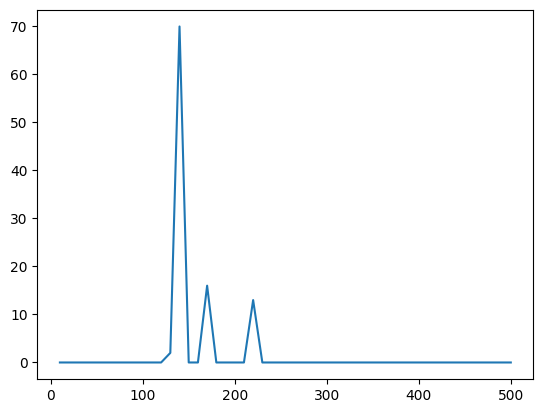

In [43]:
# Trimming bypass edges
edgelist = graph.edges.keys()
distance = []
count = 0
Bypass_edge = {} # structural variants


for edge in edgelist:
    src = graph.incoming[edge][0]
    dst = graph.outgoing[edge][0]
    spos = graph.anchor[src]['pos']
    epos = graph.anchor[dst]['pos']
    if "012920" in graph.edges[edge]['strain']: # exclude reference path
        continue
    if numpy.absolute(epos-spos)>500:
        d = min(len(graph.edges[edge]['seq']), numpy.absolute(epos-spos))
        if d > 200:
            Bypass_edge[edge] = graph.edges[edge]
            Deleted_Edge[edge] = graph.edges[edge]
            count += 1
        distance.append(d) 


y, x = numpy.histogram(distance, bins = 50, range = [0,500])
plot.plot(x[1:], y)
count

In [44]:
#Deleted_Edge.keys()

In [45]:
# delete bypass edges
# for edge in Bypass_edge:
#     if edge in graph.edges:
#         del graph.edges[edge]

for edge in Bypass_edge:
    print(edge, graph.incoming[edge], graph.outgoing[edge], Bypass_edge[edge]['strain'], 
          len(Bypass_edge[edge]['reads']))

E00037.0020 ['A000531'] ['A000004'] ['HG00438', 'HG00735', 'HG01243', 'HG01258', 'HG01361', 'HG02109', 'HG02572', 'HG02630', 'HG02717', 'HG02886', 'HG03492', 'HG03540', 'HG03579', 'NA19240', 'NA20129'] 55
E00248.0002 ['A000531'] ['A000004'] ['HG00621', 'HG00733', 'HG01952', 'HG02080', 'HG02148', 'HG03453', 'NA21309'] 19
E00347.0005 ['A000531'] ['A000004'] ['HG00673', 'HG01361', 'HG01891', 'HG02630', 'HG02717', 'HG03486', 'HG03516', 'HG03540', 'NA19240'] 13
E00655.0003 ['A000531'] ['A000004'] ['HG00733', 'HG02148', 'HG02818', 'HG03453', 'NA21309'] 7
E00855.0001 ['A000531'] ['A000004'] ['HG01123', 'HG01358'] 7
E01421.0004 ['A000531'] ['A000004'] ['HG01123', 'HG01358'] 5
E01466.0019 ['A000531'] ['A000004'] ['HG01175', 'HG03453', 'NA21309'] 4
E01540.0005 ['A000531'] ['A000004'] ['HG01243', 'HG02886', 'NA19240', 'NA20129'] 6
E01849.0018 ['A000531'] ['A000004'] ['HG01243', 'HG01891', 'HG02630', 'HG02717', 'HG02886'] 5
E01941.0015 ['A000531'] ['A000004'] ['HG01258', 'HG02055', 'HG02572', 'HG0

In [46]:
def write_gfa(AnchorInfo, Edge_info, outputfilename):
    header = ['H\tVN:Z:1.0\n']
    # add json annotation to edge and anchor sequences
    AnchorS = []
    for anchor,D in AnchorInfo.items():
        seq = D.pop('seq')
        json_string = json.dumps(D)
        AnchorS += ['S\t%s\t%s\t%s\n' % (anchor, seq, "PG:J:" + json_string)]
   
    EdgeS = []   
    Link = [] 
    for edge,edge_dict in Edge_info.items():
        seq = edge_dict.pop('seq')
        src = edge_dict.pop('src')
        dst = edge_dict.pop('dst')
        
        json_string = json.dumps(edge_dict)
        EdgeS += ['S\t%s\t%s\t%s\t%s\n' % (edge, seq, "PG:J:" + json_string, "RC:i:" + str(len(edge_dict['reads'])))]
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (src, "+", edge, "+", "0M"))
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (edge, "+", dst, "+", "0M"))     

    with open(outputfilename, 'w') as fp:
        for h in header:
            fp.write(h)
        for s in AnchorS:
            fp.write(s)
        for s in EdgeS:
            fp.write(s)
        for l in Link:
            fp.write(l)

In [47]:
for item in list(list(graph.edges.keys())):
    print(item)

E00000.0001
E00000.0002
E00000.0003
E00000.0004
E00000.0005
E00000.0006
E00000.0007
E00000.0008
E00000.0009
E00000.0010
E00000.0011
E00000.0012
E00000.0013
E00000.0014
E00000.0015
E00000.0016
E00000.0017
E00000.0018
E00000.0019
E00000.0020
E00000.0021
E00000.0022
E00000.0024
E00000.0025
E00000.0026
E00000.0027
E00000.0028
E00000.0029
E00000.0030
E00000.0031
E00000.0032
E00000.0033
E00000.0034
E00000.0035
E00000.0036
E00000.0037
E00000.0038
E00000.0039
E00000.0040
E00000.0041
E00000.0042
E00000.0043
E00000.0044
E00000.0045
E00000.0046
E00000.0047
E00000.0048
E00000.0049
E00000.0050
E00000.0051
E00000.0052
E00000.0053
E00000.0054
E00000.0055
E00000.0056
E00000.0057
E00000.0058
E00000.0059
E00000.0060
E00000.0061
E00000.0062
E00000.0063
E00000.0064
E00000.0065
E00000.0066
E00000.0067
E00000.0068
E00000.0069
E00000.0070
E00000.0071
E00000.0072
E00000.0073
E00000.0074
E00000.0075
E00000.0076
E00000.0077
E00000.0078
E00000.0079
E00000.0080
E00000.0081
E00000.0082
E00000.0083
E00000.0084
E000

In [48]:
edgelist = graph.edges.keys()
for edge in edgelist:
    graph.edges[edge]['src'] = graph.incoming[edge][0]
    graph.edges[edge]['dst'] = graph.outgoing[edge][0]

filename = 'MT_anchor_graphical_genome_k31_anno_delbypass.gfa'
write_gfa(graph.anchor, graph.edges, filename)

# construct Series Parallel Graph

In [49]:
class Find_all_Path_between_anchors:
    def __init__(self, graph, start, end, read_sets):
        self.subpath = []
        self.initial_set = read_sets
        self.find_path(graph, start, end, [], 0, self.initial_set)
        
    def find_path(self, g, start, end, sofar, depth, readset):
        
        if start == end:
            sofar1 = sofar + [end]
            if len(readset)>0:
                self.subpath.append((sofar1, readset))
            return
        
        # path not supported
        if len(readset) <1:
            return  
        
        # path not circular
        if start == "SINK":
            return
        
        depth1 = depth+ 1
        
        
        for dst in g.outgoing[start]:   
            # consider the read set in the latest 10 intervals
            if dst.startswith("E"):
                readset1 = readset & set(g.edges[dst]['reads'])
            else:
                readset1 = readset
             
            self.find_path(g, dst, end, sofar = sofar + [start], depth = depth1, readset = readset1)
            
def reconstruct_path_seq(graph, path):
    seq = ""
    for item in path:
        if item.startswith('A'):
            seq += graph.anchor[item]['seq']
        elif item.startswith("E"):
            seq += graph.edges[item]['seq']
        else:
            item += ""
    return seq

In [50]:
def find_furthest_node(node_candidate, subgraph):
    max_distance = 0
    node = ""
    for n in node_candidate:
        d = numpy.absolute(subgraph.anchor[node]['pos'] - subgraph.anchor['start_node']['pos'])
        if d > max_distance:
            node = n
    return node

In [51]:
class Get_Series_Parallel_Graph:
    
    def __init__(self, graph):
        self.initial_set = self.find_all_reads(graph)
        self.nodelist = self.series_parallel_graph_nodelist(graph)
        #print(self.nodelist)
        self.anchor, self.edges, self.outgoing, self.incoming = self.series_parallel_graph(self.nodelist, graph)

    def find_all_reads(self, graph):
        read_sets = set()
        edgelist = graph.edges.keys()
        for item in edgelist:
            readlist = graph.edges[item]['reads']
            for read in readlist:
                read_sets.add(read)
        return read_sets
    def find_furthest_node(self, node_candidate, subgraph, start_node):
        max_distance = 0
        node = ""
        for n in node_candidate:
            d = numpy.absolute(subgraph.anchor[n]['pos'] - subgraph.anchor[start_node]['pos'])
            if d > max_distance:
                node = n
        return node

    def series_parallel_graph_nodelist(self, subgraph): 
        #  need to consider the loop i.e.the last anchor to the first anchor

        start_node = sorted(subgraph.anchor.keys())[0]
        Nodelist = [start_node]

        edgelist = subgraph.outgoing[start_node]
        node_candidate = []
        for edge in edgelist:
            nodelist = subgraph.outgoing[edge]
            node_candidate += nodelist
            if nodelist[0] not in subgraph.anchor:
                    continue
        node_candidate = sorted(node_candidate)
        #node = node_candidate[-1] ## node should be selected by the largest distance instead of the sorting order
        node = self.find_furthest_node(node_candidate, subgraph, start_node)

        # find the furthurest anchor
        Nodelist.append(node) # append the furthest node
        


        while node != start_node:
            # print(node)

            edgelist = subgraph.outgoing[node]
            node_candidate = []
            for edge in edgelist:
                nodelist = subgraph.outgoing[edge]
                # exclude deadend
                if "SINK" in nodelist:
                    continue
                if nodelist[0] not in subgraph.anchor:
                    continue
                if nodelist[0] not in subgraph.outgoing:
                    continue
                node_candidate += nodelist

            node_candidate = sorted(node_candidate)
            node = self.find_furthest_node(node_candidate, subgraph, node)
            if node in set(Nodelist):
                Nodelist.append(node)
                break
            Nodelist.append(node) # append the furthest node  
                
        return Nodelist
    
    def series_parallel_graph(self, Nodelist, subgraph):
        Node_dict = {}
        Edge_dict = {}
        Outgoing_dict = {}
        Incoming_dict = {}
        for i, node in enumerate(Nodelist[:-1]):
            start_node = node
            end_node = Nodelist[i+1]
            Node_dict[start_node] = subgraph.anchor[start_node]
            # print(start_node, end_node)
            path = Find_all_Path_between_anchors(subgraph, start_node, end_node, self.initial_set)
            #print(start_node,end_node, len(path.subpath))
            index = 0
            for p, rs in path.subpath:
                edgename = 'E%05d.%04d' % (int(start_node[1:]), index)
                seq = reconstruct_path_seq(subgraph, p[1:-1])
                Edge_dict[edgename] = {}
                Edge_dict[edgename]['seq'] = seq
                Edge_dict[edgename]['src'] = start_node
                Edge_dict[edgename]['dst'] = end_node
                Edge_dict[edgename]['reads'] = list(rs)
                Edge_dict[edgename]['strain'] = list(set([item.split("_")[-1] for item in list(rs)]))

                Outgoing_dict[start_node] = Outgoing_dict.get(start_node, []) + [edgename]
                Outgoing_dict[edgename] = [end_node]

                Incoming_dict[end_node] = Incoming_dict.get(end_node, []) + [edgename]
                Incoming_dict[edgename] = [start_node]
                index += 1
        return Node_dict, Edge_dict, Outgoing_dict, Incoming_dict

In [52]:

class SubGraph:
    def __init__(self, graph, samplelist):
        self.anchor, self.edges, self.outgoing, self.incoming = self.reconstruct_sample_subgraph(graph, samplelist)

    def reconstruct_sample_subgraph(self, graph, samplelist):
        Anchor_dict = {}
        Edge_dict = {}
        Outgoing = {}
        Incoming = {}

        edgelist = list(graph.edges.keys())
        nodelist = []
        
        for edge in edgelist:
            if len(set(samplelist) & set(graph.edges[edge]['strain'])) > 0:
                Edge_dict[edge] = graph.edges[edge]
                src = graph.incoming[edge][0]
                dst = graph.outgoing[edge][0]
                
                Edge_dict[edge]['src'] = src
                Edge_dict[edge]['dst'] = dst
                
                Incoming[edge] = graph.incoming[edge]
                Incoming[dst] = Incoming.get(dst, []) + [edge]
                
                Outgoing[edge] = graph.outgoing[edge]
                Outgoing[src] = Outgoing.get(src, []) + [edge]
                
                nodelist += graph.incoming[edge]
                nodelist += graph.outgoing[edge]

        nodelist = list(set(nodelist))
        for node in nodelist:
            if node.startswith("A"):
                Anchor_dict[node] = graph.anchor[node]      
        return Anchor_dict, Edge_dict, Outgoing, Incoming

In [53]:
def find_all_reads(graph):
    read_sets = set()
    edgelist = graph.edges.keys()
    for item in edgelist:
        readlist = graph.edges[item]['reads']
        for read in readlist:
            read_sets.add(read)
    return read_sets



In [54]:
filename = './MT_anchor_graphical_genome_k31_anno_delbypass.gfa'
graph = AGG.GraphicalGenome(filename)


In [56]:
%time series_parallele_graph = Get_Series_Parallel_Graph(graph)

CPU times: user 8min 18s, sys: 8.37 s, total: 8min 27s
Wall time: 8min 46s


In [57]:
series_parallele_graph.edges['E00001.0000']

{'seq': 'TATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTGGAGCCG',
 'src': 'A000001',
 'dst': 'A000004',
 'reads': ['m54329U_200215_021808/17173064/ccs_HG02486',
  'm54329U_200215_021808/60885145/ccs_HG02486',
  'm54329U_201103_231616/6883234/ccs_HG002',
  'm54329U_200215_021808/101712266/ccs_HG02486',
  'm54329U_200215_021808/97976996/ccs_HG02486',
  'm54329U_200215_021808/67634388/ccs_HG02486',
  'm54329U_200215_021808/50006617/ccs_HG02486',
  'm54329U_200215_021808/76875208/ccs_HG02486',
  'm54329U_201103_231616/6359354/ccs_HG002',
  'm54329U_200215_021808/115803285/ccs_HG02486',
  'm54329U_201103_231616/71960591/ccs_HG002',
  'm54329U_200215_021808/62718172/ccs_HG02486',
  'm54329U_200215_021808/82709087/ccs_HG02486',
  'm54329U_200215_021808/9308693/ccs_HG02486',
  'm54329U_200215_021808/28444873/ccs_HG02486',
  'm54329U_200215_021808/22675686/ccs_HG02486',
  'm54329U_200215_021808/103809226/ccs_HG02486',
  'm54329U_200215_021808/175245542/ccs_HG02486',
  'm54329U_200215_021808/17517

In [62]:
edgelist = series_parallele_graph.edges.keys()
for edge in edgelist:
    series_parallele_graph.edges[edge]['src'] = series_parallele_graph.incoming[edge][0]
    series_parallele_graph.edges[edge]['dst'] = series_parallele_graph.outgoing[edge][0]



In [63]:
# nodelist = list(series_parallele_graph.anchor.keys())
# Node_dict = {node:series_parallele_graph.anchor[node] for node in nodelist}
# edgelist = list(series_parallele_graph.edges.keys())
# Edge_dict = {edge:series_parallele_graph.edges[edge] for edge in edgelist}

In [64]:
filename = 'MT_anchor_graphical_genome_k31_anno_series_parallele.gfa'
write_gfa(series_parallele_graph.anchor, series_parallele_graph.edges, filename)

KeyError: 'seq'

In [61]:
#series_parallele_graph.outgoing['A000001']

# Add Variants

In [65]:
import Levenshtein
def addvariants(Graph, maxlength, k,  refstrain = "012920"):
    def makeCigar(seq, ref):
        if (len(seq) > 16384) or (len(ref) > 16384):
            rmid = len(ref)/2        
            smid = len(seq)/2
            prox = makeCigar(seq[:smid],ref[:rmid])
            dist = makeCigar(seq[smid:],ref[rmid:])
            return prox+dist
        ops = Levenshtein.editops(seq,ref)
        code = ['=' for i in range(len(seq))]
        offset = 0
        for op, si, di in ops:
            if (op == "replace"):
                code[si+offset] = 'X'
            elif (op == "insert"):
                code.insert(si+offset,'D')
                offset += 1
            elif (op == "delete"):
                code[si+offset] = 'I'# LM: fixed bug here 2019-04-15
        cigar = ''
        count = 1
        prev = code[0]
        for c in code[1:]:
            if (c == prev):
                count += 1
            else:
                cigar += "%d%c" % (count, prev)
                count = 1
                prev = c
        cigar += "%d%c" % (count, prev)
        return cigar

    # check the length of the cigar string is valid
    def search_valid_size(variants,seq):
        ref_length,alt_length = 0,0
        for v in variants:
            base, op = v
            base = int(base)
            if op == '=' or op == 'X':
                ref_length += base
                alt_length += base
            elif op == 'I':
                alt_length += base
            elif op == 'D':
                ref_length += base

        return len(seq) == alt_length 

    # check the length of the cigar string is valid
    def valid_size(variants,seq,reference):
        ref_length,alt_length = 0,0
        for v in variants:
            base, op = v
            base = int(base)
            if op == '=' or op == 'X':
                ref_length += base
                alt_length += base
            elif op == 'I':
                alt_length += base
            elif op == 'D':
                ref_length += base

        assert len(seq) == alt_length 
        assert len(reference) == ref_length

    def valid_eqaul_and_mismatch(variants,seq,reference):
        ref_pos,alt_pos = 0,0
        for v in variants:
            base,op = v
            base = int(base)
            if op == '=':
                assert seq[alt_pos:alt_pos+base] == reference[ref_pos:ref_pos+base]
                ref_pos += base
                alt_pos += base
            elif op == 'X':
                assert seq[alt_pos:alt_pos+base] != reference[ref_pos:ref_pos+base]
                ref_pos += base
                alt_pos += base
            elif op == 'I':
                alt_pos += base
            elif op == 'D':
                ref_pos += base

    #assert len(reference) == ref_length
    def split(variant):
        splitVariants = []
        previous = 0
        for i in range(len(variant)):
            v = variant[i]
            if v.isdigit():
                continue
            else:
                splitVariants += [variant[previous:i]]
                splitVariants += [v]
                previous = i + 1

        numbers, types = [],[]
        for i in range(len(splitVariants)):
            v = splitVariants[i]
            if i %2 == 0:
                numbers += [v]
            else:
                types += [v]

        variant = []
        for i in range(len(numbers)):
            variant += [(numbers[i],types[i])]
        return variant

    def findBedge(Graph, src, dst, refstrain, k):
        paths = Find_all_Path_between_anchors(Graph, src, dst, {refstrain})
        subpaths = paths.subpath
        
        if len(subpaths) < 1:
            return ""
        for p, strain in subpaths:
            seq = reconstruct_path_seq(spgraph, path = p)
        return seq[k:-k]
    
        # for edge in edgelist:
        #     sequence = Graph.edges[edge]['seq'].upper()
        #     strain = Graph.edges[edge]['strain']
            
        #     if refstrain in strain:
        #         B_dst = Graph.outgoing[edge][0]
        #         if B_dst == dst:
        #             return edge
        #         else:
        #             return ""
        # else:
        #     return ''

    def GapOpenAligner(reference,sequence):
        alignments = pairwise2.align.globalms(sequence,reference,0, -6, -5, -3)
        if len(alignments) == 0:
            return ""
        alignment = alignments[0]
        seq, ref = alignment[0],alignment[1]
        cigar = gen_cigar(ref,seq)
        return cigar
    
    def gen_cigar(ref, qry):
        if len(ref) != len(qry):
            raise Exception('unequal length')
        cigar = []
        for i in range(len(ref)):
            r, q = ref[i], qry[i];
            if r == '-' and q == '-':
                raise Exception('both gaps')
            op = '=' if r is q else 'I' if r == '-' else 'D' if q == '-' else 'X';
            if len(cigar) > 0 and cigar[-1][1] is op: # add to the last operation
                cigar[-1][0] += 1
            else: cigar.append([1, op]);              # a new operation
        return "".join(map(lambda x: str(x[0]) + x[1], cigar)); # turn to string

    # mask Ns on the alternative path
    def maskNs(seq):
        seq = seq.upper()
        newseq = ''
        for i in seq:
            if i not in "AGCT":
                newseq += i.lower()
            else:
                newseq += i
        return newseq
    
    def add_variants(Graph, maxlength, refstrain, k, gapopen = False):
        Nodelist = sorted(Graph.anchor.keys())
        #Nodelist = ["SOURCE"] + Nodelist
        for i in range(len(Nodelist)-1):
            sanchor = Nodelist[i]
            eanchor = Nodelist[i+1]
            edgelist = Graph.outgoing[sanchor]
            ref_seq = findBedge(Graph, sanchor, eanchor, "NC_012920", k).upper()
            # if ref_edge == "":
            #     continue

            # ref_seq = Graph.edges[ref_edge]['seq'].upper()
            ref_length = len(ref_seq)

            if ref_length > maxlength:
                continue
            if ref_length < 1:
                continue

            for alt_edge in edgelist:
                alt_seq = maskNs(Graph.edges[alt_edge]['seq']) # mask Ns
                alt_length = len(alt_seq)
                
                if alt_seq == ref_seq:
                    Graph.edges[alt_edge]['variants'] = str(ref_length) + '='
                    continue

                if alt_length > maxlength:
                    continue

                if gapopen:
                    delta = abs(alt_length - ref_length)
                    if delta > 100:
                        if delta > alt_length or delta > ref_length:
                            cigar = GapOpenAligner(ref_seq, alt_seq)
                            if len(cigar) == 0:
                                continue
                            variants = split(cigar)
                            valid_size(variants, alt_seq, ref_seq)
                            valid_eqaul_and_mismatch(variants, alt_seq, ref_seq)
                        else:
                            cigar = makeCigar(alt_seq, ref_seq)
                            variants = split(cigar)
                            valid_size(variants, alt_seq, ref_seq)
                            valid_eqaul_and_mismatch(variants, alt_seq, ref_seq)
                    else:
                        cigar = makeCigar(alt_seq, ref_seq)
                        variants = split(cigar)
                        valid_size(variants, alt_seq, ref_seq)
                        valid_eqaul_and_mismatch(variants, alt_seq, ref_seq)
                else:
                    cigar = makeCigar(alt_seq, ref_seq)
                    variants = split(cigar)
                    valid_size(variants, alt_seq, ref_seq)
                    valid_eqaul_and_mismatch(variants, alt_seq, ref_seq)

                Graph.edges[alt_edge]['variants'] = cigar
    
    add_variants(Graph, maxlength, refstrain, k, gapopen = True)
    return Graph

In [66]:
filename = './MT_anchor_graphical_genome_k31_anno_series_parallele.gfa'
spgraph = AGG.GraphicalGenome(filename)
graph = addvariants(spgraph, 3000, 31)

In [67]:
edgelist = sorted(spgraph.edges.keys())
for edge in edgelist:
    print(spgraph.edges[edge].get('variants', ""))


52=
18=1X33=
18=1X20=1I13=
17=1I1=1X33=
16=1D1=1X33=
6=1I12=1X33=
18=1X30=1I3=
18=1X13=1I20=
18=1X30=1D2=
18=1X32=1D
18=1X26=1D6=
5=1D12=1X33=
9=1X8=1X33=
9=1X7=1I1=1X33=
9=1X28=1X1=1X11=
5=1D3=1X8=1X33=
9=1X1=1I7=1X33=
9=1X6=1D1=1X33=
8=1I10=1X33=
1I18=1X33=
6=1I11=1I1=1X33=
5=1D10=1D1=1X33=
17=2I1=1X33=
17=1I1=1X20=1I13=
18=1X1I33=
18=1X14=1I19=
11=1I7=1X33=
18=1X4=1I29=
9=1I9=1X33=
1=1I17=1X33=
6=2X10=1X33=
10=1I8=1X33=
18=1X22=1I11=
18=1X14=1D18=
18=1X29=1I4=
18=1X15=1X3=1X13=
17=1I1=1X15=1X3=1X13=
18=1X32=1X
18=1X1I33=
38=1X13=
125=1X46=2I1=1I56=
125=1X46=2I6=1I41=1I10=
125=1X46=2I6=1I41=1D9=
125=1X46=2I6=1I47=1D3=
125=1X46=2I6=1I37=1I14=
125=1X46=1I1=1I56=
125=1X46=1I6=1I41=1I10=
125=1X46=1I6=1I41=1D9=
125=1X46=1I6=1I47=1I4=
125=1X46=1I6=1I37=1I14=
125=1X46=2I1=2I56=
125=1X46=2I6=2I41=1I10=
125=1X47=1I56=
125=1X52=1I41=1I10=
125=1X52=1I37=1I14=
125=1X46=3I1=1I56=
125=1X46=3I6=1I41=1I10=
111=1D13=1X46=3I1=1I56=
111=1D13=1X46=2I1=1I56=
5=1X6=1X112=1X47=1I56=
5=1X6=1X112=1X52=1I41=1

In [68]:
edgelist = graph.edges.keys()
for edge in edgelist:
    graph.edges[edge]['src'] = graph.incoming[edge][0]
    graph.edges[edge]['dst'] = graph.outgoing[edge][0]

filename = 'MT_anchor_graphical_genome_k31_anno_series_parallele.gfa'
write_gfa(graph.anchor, graph.edges, filename)

# Merging reads support < 5% paths to the available paths and call variants

In [113]:
filename = 'MT_anchor_graphical_genome_k31_anno_series_parallele.gfa'
spgraph = AGG.GraphicalGenome(filename)

In [114]:
samplelist=set()
edgelist = list(spgraph.edges.keys())
for edge in edgelist:
    samplelist = samplelist | set(spgraph.edges[edge]['strain'])

len(samplelist)

47

In [109]:
threshold = 0.05
def prune_under_supported_path(spgraph, samplelist, threshold = 0.05):
    for sample in samplelist:
        sub_spgraph = AGG.SubGraph(spgraph, [sample])
        nodelist = sorted(sub_spgraph.outgoing.keys())    
        readsets = find_all_reads(sub_spgraph)
        readnum = sum([1 for r in list(readsets) if r.endswith(sample)])
        print(readnum)
        for i in range(len(nodelist)-1):
            sanchor = nodelist[i]
            eanchor = nodelist[i+1]
            paths = sub_spgraph.outgoing[sanchor]
            supported = [p for p in paths if p.startswith('E') if len(set(sub_spgraph.edges[p]['reads'])) > readnum * threshold]
            unsupported = [p for p in paths if p not in supported]
            # delete unsupported
            for e in unsupported:
                if e.startswith("E"):
                    del sub_spgraph.edges[e]

    return sub_spgraph

In [115]:
def get_variant_position(cigar):
    ref_pos = []
    alt_pos = []
    alt_i = 0
    ref_i = 0
    for i, s in enumerate(cigar):
        if s == 'I':
            if ref_i > 0:
                ref_pos.append(ref_i-1)
            else:
                ref_pos.append(ref_i)    
            alt_pos.append(alt_i)
            alt_i += 1
        if s == 'D':
            ref_pos.append(ref_i)
            if alt_i > 0:
                alt_pos.append(alt_i-1)
            else:
                alt_pos.append(alt_i)
            ref_i += 1
            
        if s == 'X':
            ref_pos.append(ref_i)
            alt_pos.append(alt_i)
            alt_i += 1
            ref_i += 1
            
        if s == '=':
            alt_i += 1
            ref_i += 1

    return ref_pos, alt_pos

def find_allVar(graph, refstrain, founder, k):
    Var = {} # Var[refpos]['edgename'] = ['A']
    nodelist = sorted(graph.anchor.keys())
    node = nodelist[0]
    lastnode = nodelist[-1]
    while node != lastnode:
        edgelist = graph.outgoing[node]
        
        for edge in edgelist:
            if edge not in graph.edges:
                continue
            if refstrain in graph.edges[edge]['strain']:
                refseq = graph.edges[edge]['seq']
                refedge = edge
                break
        else:
            node = graph.outgoing[edge][0]
            continue
                
        for edge in edgelist:
            if edge not in graph.edges:
                continue
            cigar = graph.edges[edge].get('variants', "")
            if len(cigar) == 0:
                continue
            if node != "SOURCE":
                refstart = int(graph.anchor[node]["pos"]) + k
            else:
                refstart = int(graph.Nodecoordinates(node, strainlist = founder)[refstrain])
            
            refpos, altpos = get_variant_position(AGG.processCigar(cigar))
            #print refpos, altpos
            alt_seq = graph.edges[edge]['seq']
            for i, rp in enumerate(refpos):
                pos = refstart + rp
                Var[pos] = Var.get(pos, {})
                Var[pos][edge] = Var[pos].get(edge, {})                
                Var[pos][edge]['base'] = Var[pos][edge].get('base', "") + alt_seq[altpos[i]]
                Var[pos][edge]['altoffset'] = Var[pos][edge].get('altoffset', []) + [altpos[i]]
                Var[pos][refedge] = Var[pos].get(refedge, {})
                Var[pos][refedge]['base'] = refseq[refpos[i]]
                Var[pos]['refbase'] = Var[pos][refedge]['base']
                
        node = graph.outgoing[edge][0]    #print cigar, refpos, altpos
    return Var

In [91]:
# for pos, D in Var.items():
#     print(pos, D)

In [116]:
# Single Sample VCF

def get_VCF_file(Var, samplelist):
    Mat = {}

    for pos, D in Var.items():
        Mat[pos] = {}
        for edge, B in D.items():
            if edge == "refbase":
                continue
            for strain in samplelist:
                Mat[pos][strain] = Mat[pos].get(strain, set()) | set([B['base']])

    # write VCF
    VCF = {}
    for pos, D in Mat.items():
        refbase = Var[pos]['refbase']
        if list(D.values())[0] == set([refbase]):
            continue    
        VCF[pos]= VCF.get(pos, {})
        for strain, base in D.items():
            VCF[pos]["CHROM"] = "chrM"
            VCF[pos]["POS"] = pos
            VCF[pos]['ID'] = "."
            VCF[pos]['REF'] = refbase
            #print(base - set([refbase]))
            VCF[pos]['ALT'] = ",".join(base - set([refbase]))
            VCF[pos]['QUAL'] = "."
            VCF[pos]['FILTER'] = "."
            VCF[pos]['INFO'] = "."
            VCF[pos]['FORMAT'] = "GT"
            #print(base)
            # allelelist = []
            # if refbase in base:
            #     allelelist += [0]

            # for i,s in enumerate(base - set([refbase])):
            #     allelelist += [i+1]
            # VCF[pos][strain] = "/".join([str(item) for item in allelelist])
            VCF[pos][strain] = "/".join([str(item) for item in base])
    return VCF

In [120]:
k = 31
refstrain = "012920"
# samplelist = ['HG00438', "HG00621"]
# samplelist = ['HG002']
#sub_graph = prune_under_supported_path(spgraph, samplelist, threshold = 0.05)
Var = find_allVar(spgraph, refstrain, samplelist, k)
VCF = get_VCF_file(Var, samplelist)
df = pd.DataFrame(VCF).T


In [123]:
df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG01109,...,HG02148,HG02145,NA19240,HG02622,HG03098,HG01243,HG02717,012920,HG02559,HG02572
73,chrM,73,.,A,"TG,G,GG",.,.,.,GT,0|1|2|3,...,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3,0|1|2|3
93,chrM,93,.,A,G,.,.,.,GT,0|1,...,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1
71,chrM,71,.,G,GG,.,.,.,GT,0|1,...,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1
103,chrM,103,.,G,C,.,.,.,GT,0|1,...,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1
86,chrM,86,.,C,A,.,.,.,GT,0|1,...,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1,0|1


In [30]:
# Mat = {}
# for pos, D in Var.items():
#     Mat[pos] = {}
#     for edge, B in D.items():
#         if edge == "refbase":
#             continue
#         print(edge, B)
#         strainlist = spgraph.edges[edge]['strain']
#         for strain in strainlist:
#             Mat[pos][strain] = Mat[pos].get(strain, set()) | set([B['base']])

In [23]:
# Mat[432]

In [78]:
# Mat = {}
# for pos, D in Var.items():
#     Mat[pos] = {}
#     Mat[pos]["CHROM"] = "chrM"
#     Mat[pos]["POS"] = pos
#     Mat[pos]['ID'] = "."
#     Mat[pos]['REF'] = D['refbase']
#     alternative_allele = set()

#     for edge, B in D.items():
#         if edge == 'refbase':
#             ref_base = B
#             continue
#         alternative_allele.add(B['base'])
#     alternative_allele = sorted(alternative_allele.remove(ref_base))

#     Mat[pos]['ALT'] = ",".join(alternative_allele)
#     Mat[pos]['QUAL'] = "."
#     Mat[pos]['FILTER'] = "."
#     Mat[pos]['INFO'] = "."
#     Mat[pos]['FORMAT'] = "GT"
#     for strain in strainlist:
#         Mat[pos][strain] = set()
#         for edge, B in D.items():
#             if edge == 'refbase':
#                 continue
#             Mat[pos][strain] = Mat[pos].get(strain, set()) | set([B['base']])

#         allelelist = []
#         if D['refbase'] in Mat[pos][strain]:
#             allelelist += [0]
#         else:
#             for i in range(len(alternative_allele)):
#                 if alternative_allele[i] in Mat[pos][strain]:
#                     allelelist += [i+1]
#         #Mat[pos][strain] = "|".join([str(i) for i in allelelist])



In [83]:
Var[8017]

{'E00257.0047': {'base': 'TC', 'altoffset': [21, 22]},
 'E00257.0000': {'base': 'C'},
 'refbase': 'C'}

In [82]:
df = pd.DataFrame(VCF).T
df


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG00438
432,chrM,432,.,A,C,.,.,.,GT,0|1
957,chrM,957,.,C,CC,.,.,.,GT,0|1
1868,chrM,1868,.,G,A,.,.,.,GT,0|1
2129,chrM,2129,.,G,A,.,.,.,GT,0|1
2492,chrM,2492,.,G,C,.,.,.,GT,0|1
2939,chrM,2939,.,C,A,.,.,.,GT,0|1
3571,chrM,3571,.,C,CC,.,.,.,GT,0|1
5436,chrM,5436,.,A,C,.,.,.,GT,0|1
5899,chrM,5899,.,C,CC,.,.,.,GT,0|1
6186,chrM,6186,.,C,T,.,.,.,GT,0|1


In [84]:
df.to_csv("HG00438_variant.vcf", sep= '\t')

In [85]:
df.sort_index

<bound method DataFrame.sort_index of       CHROM    POS ID REF ALT QUAL FILTER INFO FORMAT HG00438
432    chrM    432  .   A   C    .      .    .     GT     0|1
957    chrM    957  .   C  CC    .      .    .     GT     0|1
1868   chrM   1868  .   G   A    .      .    .     GT     0|1
2129   chrM   2129  .   G   A    .      .    .     GT     0|1
2492   chrM   2492  .   G   C    .      .    .     GT     0|1
2939   chrM   2939  .   C   A    .      .    .     GT     0|1
3571   chrM   3571  .   C  CC    .      .    .     GT     0|1
5436   chrM   5436  .   A   C    .      .    .     GT     0|1
5899   chrM   5899  .   C  CC    .      .    .     GT     0|1
6186   chrM   6186  .   C   T    .      .    .     GT     0|1
6569   chrM   6569  .   C  CC    .      .    .     GT     0|1
7490   chrM   7490  .   A   C    .      .    .     GT     0|1
8017   chrM   8017  .   C  TC    .      .    .     GT     0|1
8557   chrM   8557  .   G   C    .      .    .     GT     0|1
11215  chrM  11215  .   C   A   

In [86]:
# validation
refgenome = '/Users/suhang/Analysis/Mitochondrial/MitoHifi/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)
contig = "+" + contig # reference sequences

In [88]:
contig[432], contig[957], contig[6186], contig[13230] # Yah!

('A', 'C', 'C', 'C')

# estimate haplotype number

In [ ]:
# validation
def validate_sp_graph(series_parallelgraph):
    nodelist = series_parallelgraph.anchor.keys()
    for node in nodelist:
        edgelist = series_parallelgraph.outgoing[node]
        outgoing_nodelist = []
        for edge in edgelist:
            outgoing_nodelist.append(series_parallelgraph.edges[edge]['dst'])
            outgoing_nodelist.append(series_parallelgraph.outgoing[edge][0])
        outgoing_nodelist = set(outgoing_nodelist)
        assert len(outgoing_nodelist) == 1
    print("PASS")

In [ ]:
filename = 'MT_anchor_graphical_genome_k31_anno_series_parallele.gfa'
series_parallele_graph = AGG.GraphicalGenome(filename)

edgelist = series_parallele_graph.edges.keys()
for edge in edgelist:
    series_parallele_graph.edges[edge]['src'] = series_parallele_graph.incoming[edge][0]
    series_parallele_graph.edges[edge]['dst'] = series_parallele_graph.outgoing[edge][0]


validate_sp_graph(series_parallele_graph)

PASS


In [ ]:
#series_parallele_graph.anchor

In [ ]:
itemlist = series_parallele_graph.outgoing.keys()
haplotype_num = []
for item in itemlist:
    if item.startswith("A"):
        haplotype_num.append(len(series_parallele_graph.outgoing[item]))
max(haplotype_num)

541

In [ ]:
from itertools import combinations
from random import sample as S


def find_sample_list(graph):
    samplelist = set()
    edgelist = graph.edges.keys()
    for item in edgelist:
        samples = graph.edges[item]['strain']
        samplelist = samplelist | set(samples)
    return list(samplelist)


def read_sets_supporting_path(graph, samplelist, subgraph):
    read_sets = set()
    edgelist = subgraph.edges.keys()
    for item in edgelist:
        readlist = graph.edges[item]['reads']
        for sample in samplelist:
            for read in readlist:
                if read.endswith(sample):
                    read_sets.add(read)
    return read_sets

In [ ]:


samplelist = find_sample_list(series_parallele_graph)
Info = []

# combination of 2
experimentlist = S(list(combinations(samplelist, 2)),3) + S(list(combinations(samplelist, 3)),3) + S(list(combinations(samplelist, 5)),3)
#l = sample(list(combinations(samplelist, 10)),1) + + sample(list(combinations(samplelist, 20)),1) + + sample(list(combinations(samplelist, 30)),1) + + sample(list(combinations(samplelist, 46)),1)
experimentlist.append(samplelist[:10])
experimentlist.append(samplelist[10:30])
experimentlist.append(samplelist[13:33])
experimentlist.append(samplelist[20:])
experimentlist.append(samplelist[:15] + samplelist[-15:])
experimentlist.append(samplelist[:40])
experimentlist.append(samplelist[-40:])
experimentlist.append(samplelist)
for sample in experimentlist:
    print(list(sample))

['HG02080', 'HG02145']
['HG02109', 'HG01928']
['HG02572', 'HG03540']
['HG00733', 'NA20129', 'HG02818']
['HG00741', 'HG02717', 'HG03453']
['HG02572', 'HG03492', 'HG03516']
['HG02559', 'HG02055', '012920', 'HG03486', 'HG03540']
['HG02886', 'HG02717', 'HG02723', 'HG03540', 'HG00621']
['HG01361', 'HG01978', 'HG01928', 'HG02486', 'HG00438']
['HG02886', 'HG02109', 'HG00741', 'HG02080', 'HG02559', 'HG01891', 'HG00735', 'HG00673', 'HG01361', 'HG01106']
['HG01952', 'HG02145', 'HG02572', 'HG01258', 'HG01109', 'HG01123', 'HG01358', 'HG02148', 'HG02630', 'HG01978', 'HG03492', 'HG02717', 'HG01243', 'NA18906', 'HG01071', 'HG02055', 'HG02622', 'NA19240', 'NA21309', 'HG03579']
['HG01258', 'HG01109', 'HG01123', 'HG01358', 'HG02148', 'HG02630', 'HG01978', 'HG03492', 'HG02717', 'HG01243', 'NA18906', 'HG01071', 'HG02055', 'HG02622', 'NA19240', 'NA21309', 'HG03579', 'HG03516', 'HG00733', '012920']
['HG03492', 'HG02717', 'HG01243', 'NA18906', 'HG01071', 'HG02055', 'HG02622', 'NA19240', 'NA21309', 'HG03579',

In [ ]:
for sample in samplelist:
    sample = list([sample]) + ['NC_012920']
    #print(sample)

    subgraph = SubGraph(series_parallele_graph, sample)
    read_sets = read_sets_supporting_path(series_parallele_graph, sample, subgraph)
    try:
        spgraph = Get_Series_Parallel_Graph(subgraph)
    except:
        print(sample, "Failed")
        continue
    validate_sp_graph(spgraph)
    maximal_parallel_path = []
    nodelist = spgraph.anchor.keys()

    for node in nodelist:
        maximal_parallel_path.append(len(spgraph.outgoing[node]))
    print(sample, len(read_sets), max(maximal_parallel_path))
    Info.append((sample, len(read_sets),max(maximal_parallel_path) ))
        


PASS
['HG02886', 'NC_012920'] 755 87
PASS
['HG02109', 'NC_012920'] 93 16
PASS
['HG00741', 'NC_012920'] 8 4
PASS
['HG02080', 'NC_012920'] 96 20
['HG02559', 'NC_012920'] Failed
PASS
['HG01891', 'NC_012920'] 227 36
PASS
['HG00735', 'NC_012920'] 65 14
PASS
['HG00673', 'NC_012920'] 140 29
PASS
['HG01361', 'NC_012920'] 396 40
PASS
['HG01106', 'NC_012920'] 17 6
PASS
['HG01952', 'NC_012920'] 100 19
['HG02145', 'NC_012920'] Failed
PASS
['HG02572', 'NC_012920'] 423 44
PASS
['HG01258', 'NC_012920'] 478 44
PASS
['HG01109', 'NC_012920'] 61 16
PASS
['HG01123', 'NC_012920'] 601 46
PASS
['HG01358', 'NC_012920'] 585 44
['HG02148', 'NC_012920'] Failed
PASS
['HG02630', 'NC_012920'] 821 68
['HG01978', 'NC_012920'] Failed
PASS
['HG03492', 'NC_012920'] 256 33
['HG02717', 'NC_012920'] Failed
PASS
['HG01243', 'NC_012920'] 394 56
PASS
['NA18906', 'NC_012920'] 86 16
['HG01071', 'NC_012920'] Failed
PASS
['HG02055', 'NC_012920'] 335 44
PASS
['HG02622', 'NC_012920'] 23 6
PASS
['NA19240', 'NC_012920'] 882 87
PASS
[

In [ ]:
for sample in experimentlist:
    sample = list(sample) + ['NC_012920']
    #print(sample)

    subgraph = SubGraph(series_parallele_graph, sample)
    read_sets = read_sets_supporting_path(series_parallele_graph, sample, subgraph)
    spgraph = Get_Series_Parallel_Graph(subgraph)
    validate_sp_graph(spgraph)
    maximal_parallel_path = []
    nodelist = spgraph.anchor.keys()

    for node in nodelist:
        maximal_parallel_path.append(len(spgraph.outgoing[node]))
    print(sample, len(read_sets), max(maximal_parallel_path))
    Info.append((sample, len(read_sets),max(maximal_parallel_path) ))
        


PASS
['HG02080', 'HG02145', 'NC_012920'] 165 30
PASS
['HG02109', 'HG01928', 'NC_012920'] 111 18
PASS
['HG02572', 'HG03540', 'NC_012920'] 789 67
PASS
['HG00733', 'NA20129', 'HG02818', 'NC_012920'] 771 52
PASS
['HG00741', 'HG02717', 'HG03453', 'NC_012920'] 988 71
PASS
['HG02572', 'HG03492', 'HG03516', 'NC_012920'] 862 91
PASS
['HG02559', 'HG02055', '012920', 'HG03486', 'HG03540', 'NC_012920'] 1054 102
PASS
['HG02886', 'HG02717', 'HG02723', 'HG03540', 'HG00621', 'NC_012920'] 2408 137
PASS
['HG01361', 'HG01978', 'HG01928', 'HG02486', 'HG00438', 'NC_012920'] 526 52
PASS
['HG02886', 'HG02109', 'HG00741', 'HG02080', 'HG02559', 'HG01891', 'HG00735', 'HG00673', 'HG01361', 'HG01106', 'NC_012920'] 1795 172
PASS
['HG01952', 'HG02145', 'HG02572', 'HG01258', 'HG01109', 'HG01123', 'HG01358', 'HG02148', 'HG02630', 'HG01978', 'HG03492', 'HG02717', 'HG01243', 'NA18906', 'HG01071', 'HG02055', 'HG02622', 'NA19240', 'NA21309', 'HG03579', 'NC_012920'] 7179 382
PASS
['HG01258', 'HG01109', 'HG01123', 'HG01358

In [ ]:
Info

[(['HG02886', 'NC_012920'], 755, 87),
 (['HG02109', 'NC_012920'], 93, 16),
 (['HG00741', 'NC_012920'], 8, 4),
 (['HG02080', 'NC_012920'], 96, 20),
 (['HG01891', 'NC_012920'], 227, 36),
 (['HG00735', 'NC_012920'], 65, 14),
 (['HG00673', 'NC_012920'], 140, 29),
 (['HG01361', 'NC_012920'], 396, 40),
 (['HG01106', 'NC_012920'], 17, 6),
 (['HG01952', 'NC_012920'], 100, 19),
 (['HG02572', 'NC_012920'], 423, 44),
 (['HG01258', 'NC_012920'], 478, 44),
 (['HG01109', 'NC_012920'], 61, 16),
 (['HG01123', 'NC_012920'], 601, 46),
 (['HG01358', 'NC_012920'], 585, 44),
 (['HG02630', 'NC_012920'], 821, 68),
 (['HG03492', 'NC_012920'], 256, 33),
 (['HG01243', 'NC_012920'], 394, 56),
 (['NA18906', 'NC_012920'], 86, 16),
 (['HG02055', 'NC_012920'], 335, 44),
 (['HG02622', 'NC_012920'], 23, 6),
 (['NA19240', 'NC_012920'], 882, 87),
 (['NA21309', 'NC_012920'], 602, 61),
 (['HG03579', 'NC_012920'], 386, 42),
 (['HG03516', 'NC_012920'], 185, 28),
 (['HG00733', 'NC_012920'], 281, 28),
 (['HG03486', 'NC_012920

In [ ]:
df = pd.DataFrame(Info, columns = ["sample", "read_num", "hapnum"])
df.to_csv("./Haplotype_num.csv")

Text(0, 0.5, 'haplotype number')

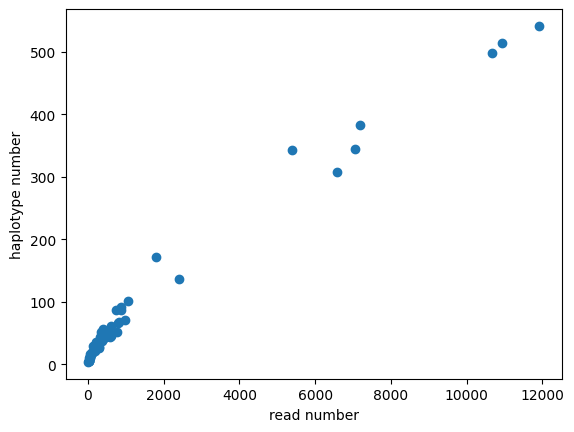

In [ ]:
#df = pd.read_csv("./", index_col=0)
df = df.sort_values(by = 'read_num')
plot.scatter(df['read_num'].values, df['hapnum'].values)
plot.xlabel("read number")
plot.ylabel("haplotype number")

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:

X = df['read_num'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df['hapnum'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

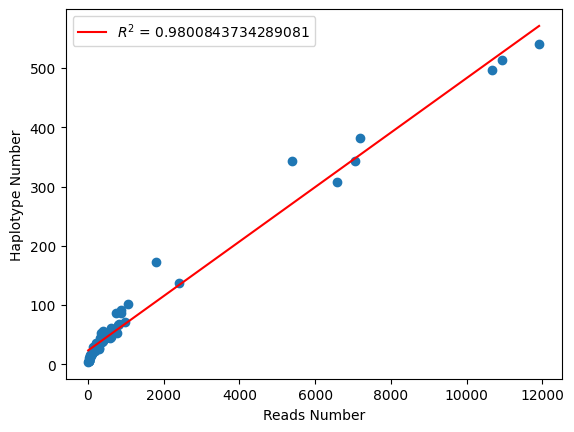

In [ ]:
plot.scatter(X, Y)
plot.plot(X, Y_pred, color='red', label = "$R^2$ = %s" % str(r2_score(Y, Y_pred)))
plot.xlabel("Reads Number")
plot.ylabel("Haplotype Number")
plot.legend()
plot.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
r2_score(Y, Y_pred)

0.9800843734289081